# Preface

In [218]:
# IMPORTS
import os
import string
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

# Task 5.1: News Article - Preprocessing


In a first step, we are going to process news articles in order to try to apply clustering algorithms. The news article corpus-30docs includes 30 news articles from the domains of science, religion and politics (10 documents for each domain). Import the documents into your process and vectorize them using stopword removal and stemming (Porter). If necessary, transform all tokens to their lower cased version. How large are the resulting document vectors?

In [123]:
# Prep work
data_dir = "../data/"
doc_dirs = ["sci.space", "soc.religion.christian", "talk.politics.guns"]
doc_paths = []

# Get a list of all (relative) filepaths
for d in doc_dirs:
    for f in os.listdir(os.path.join(data_dir, d)):
        doc_paths.append(os.path.join(data_dir, d, f))
    
# Create a custom Porter Stemmer that suits sklearn
class PortStem(object):
    def __init__(self):
        self.ps = PorterStemmer()
    def __call__(self, doc):
        return [self.ps.stem(word) for word in word_tokenize(doc)]

# Initiate a new vectorizer
vectorizer = CountVectorizer(input="filename",
                             stop_words="english", 
                             tokenizer=PortStem())

# creating the bag of words
bow = vectorizer.fit_transform(doc_paths)

# evaluate num of features
print(bow.shape)

(30, 3027)


The resulting Dataframe has **3027** attributes identified. Unfortunately the combination of `PorterStemmer()` and `word_tokenize` did not remove punctuation or numbers. Therefore a more advanced Tokenizer shall be used that:
1. replaces punctuation and numbers to blanks
2. stems based on the Porter algorithm

In [359]:
# Create a more advanced tokenizer
class PortStemNoPunctNum(object):
    def __init__(self):
        self.ps = PorterStemmer()
    def __call__(self, doc):
        return [porter.stem(word)
                for word 
                in word_tokenize(
                doc.translate(
                    str.maketrans(string.punctuation + "0123456789",' '*len(string.punctuation + "0123456789"))))]
    
# Initiate a new (advanced) vectorizer
vectorizer_adv = CountVectorizer(input="filename",
                                 stop_words="english",
                                 tokenizer=PortStemNoPunctNum())

# creating the bag of words
bow_adv = vectorizer_adv.fit_transform(doc_paths)

# evaluate num of features
print(bow_adv.shape)

(30, 2588)


The new Bag-of-Words only contains features without punctuation(`!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~`) and numbers. **The overall number of features is 2588 features**

---
# Task 5.2: News Article - Clustering
Having imported the documents and transformed them into vectors, apply a k-means clustering using k = 3. How many documents ended up in the wrong cluster? What can you do to improve the clustering? 

In [201]:
# generating a TF-IDF 
tfidf_trans = TfidfTransformer()
tfidf = tfidf_trans.fit_transform(bow_adv)

# Initating, fitting the k-means learner & predicting
km3 = KMeans(n_clusters=3, random_state=42)
y_pred = km3.fit_predict(tfidf)
y_pred.reshape(3, 10)

array([[1, 2, 2, 2, 2, 2, 2, 1, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 1, 2, 2, 2, 2, 2, 2, 1]], dtype=int32)

All the samples from the religion domain are put in the "right" cluster whereas k-means fails for the scientific and politcal cluster. Independent from assigning a 1 or a 2 to either one of the clusters one cluster has the "accuracy" of 80% and the other an "accuracy" of 20%.

In [211]:
# Compare to clustering based on raw tf
y_pred_tf = km3.fit_predict(bow_adv)
y_pred_tf.reshape(3, 10)

array([[2, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

Clustering on the raw term frequency leads to an overall decrease of accuracy.

---
# Task 5.3: News Article - Improved Clustering
Does the distribution of frequent terms help you to further improve the clustering by using any of the prune methods of the Process Documents from File operator?

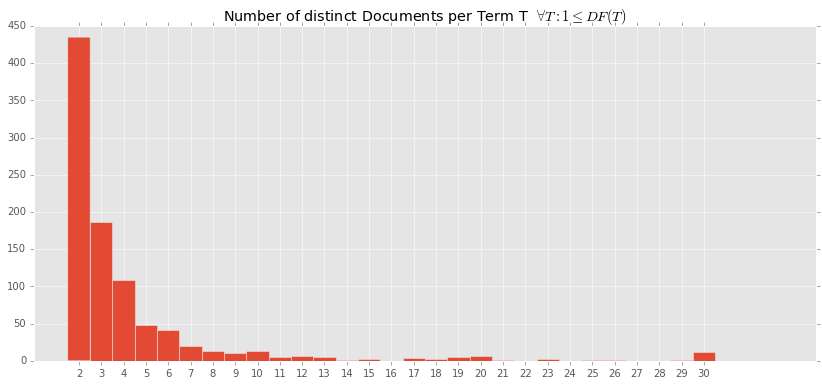

In [389]:
# Create new word vectorizer that stores '1' for non-zero TFs
binary_vectorizer = CountVectorizer(input="filename",
                                    stop_words="english",
                                    tokenizer=PortStemNoPunctNum(),
                                    binary=True
                                   )
# create binary bag-of-words 
bin_tf = binary_vectorizer.fit_transform(doc_paths)

df_min_2 = np.apply_along_axis(np.sum, axis=0, arr=bin_tf.toarray())[
    np.apply_along_axis(np.sum, axis=0, arr=bin_tf.toarray()) > 1
]

# evaluate document frequency for words that occur more than once
plt.rcParams["figure.figsize"] = [14, 6]
d = np.diff(np.unique(df_min_2)).min()
left_of_first_bin = df_min_2.min() - float(d)/2
right_of_last_bin = df_min_2.max() + float(d)/2
plt.hist(df_min_2, np.arange(left_of_first_bin, right_of_last_bin + d, d))
plt.xticks(range(np.min(df_min_2), np.max(df_min_2)+1))
plt.title("Number of distinct Documents per Term T  $ \\forall T: 1\leq DF(T) $ ")
plt.savefig("../figures/textmining/distinct-documents-per-term.png")
plt.show()

As the histogram shows the majority of terms are only present in two distinct documents. One could try to limit the number of DF into a certain range - cutting of the domain specific stopwords as well as very common words.

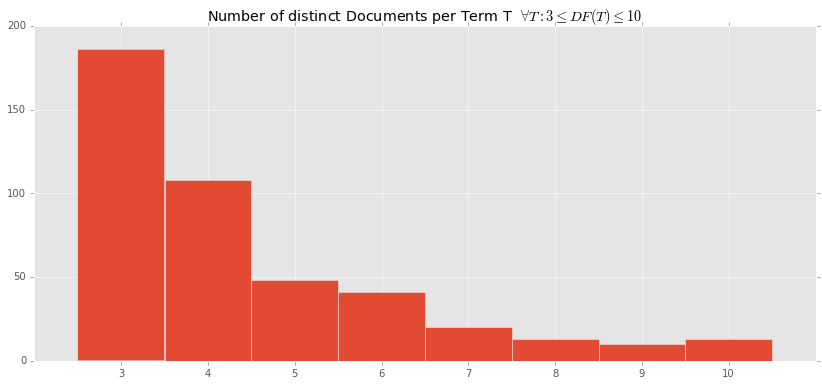

In [390]:
# Create new word vectorizer that preprunes terms 
# that occur in less than 4 or more than 10 documents
bin_vectorizer_pruned = CountVectorizer(input="filename",
                                        stop_words="english",
                                        tokenizer=PortStemNoPunctNum(),
                                        min_df = 3,
                                        max_df = 10,
                                        binary = True
                                        )

# create binary bag-of-words 
bin_tf = bin_vectorizer_pruned.fit_transform(doc_paths)

df_3_to_10 = np.apply_along_axis(np.sum, axis=0, arr=bin_tf.toarray())

# evaluate document frequency for words that occur more than once
plt.rcParams["figure.figsize"] = [14, 6]
d = np.diff(np.unique(df_3_to_10)).min()
left_of_first_bin = df_3_to_10.min() - float(d)/2
right_of_last_bin = df_3_to_10.max() + float(d)/2
plt.hist(df_3_to_10, np.arange(left_of_first_bin, right_of_last_bin + d, d))
plt.xticks(range(np.min(df_3_to_10), np.max(df_3_to_10)+1))
plt.title("Number of distinct Documents per Term T  $ \\forall T: 3 \leq DF(T) \leq 10$ ")
plt.savefig("../figures/textmining/distinct-documents-per-term-pruned.png")
plt.show()

In [404]:
vectorizer_pruned = CountVectorizer(input="filename",
                                    stop_words="english",
                                    tokenizer=PortStemNoPunctNum(),
                                    min_df = 3,
                                    max_df = 10
                                   )

# create a bag of words (TF) on pruned vectorizer
bow_tf_pruned = vectorizer_pruned.fit_transform(doc_paths)

# create a bag of words (TF-IDF) on pruned vectorizer
bow_tfidf_pruned = tfidf_trans.fit_transform(bow_tf_pruned)

# Compare to clustering based on raw tf
y_pred_df_pruned_tf = km3.fit_predict(bow_tf_pruned)
y_pred_df_pruned_tfidf = km3.fit_predict(bow_tfidf_pruned)

# Evaluate clustering after pruning
print("TF:\n{}\n\nTFIDF:\n{}"
      .format(y_pred_df_pruned_tf.reshape((3,10)), y_pred_df_pruned_tfidf.reshape((3, 10))))

TF:
[[2 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]]

TFIDF:
[[2 2 1 2 2 2 2 2 1 2]
 [0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1]]


**Pruning to a document frequency in the range of 3 to 10 and calculating the TFIDF improves the clustering significantly**. The overall "accuracy" of the clustering is around 93% (2 out of 30 articles are misclassified).

---
# Task 5.4: Job Postings: Preprocessing
In a second step, we will focus on the classification of job postings. The jobpostings.xls  file contains 500 descriptions of job postings belonging to 30 different job categories like sales and real estate. Our main goal is to learn a classification model, which is capable to predict the correct category for a new job posting. Therefore, import the data into RapidMiner using the Read Excel and the Process Document from Data operators. Convert the textual description into a vector by applying tokenization and other preprocessing steps. In order to learn a good classification model, have a look at the generated attributes and basic setup for the preprocessing which removes noisy and misleading tokens.

---
# Task 5.5: Job Postings - Classification
What levels of accuracy can you reach applying different classi cation methods and preprocessing settings?